## MNIST digit classification with Kernel Perceptron

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve, learning_curve
from sklearn.base import BaseEstimator

In [2]:
data = np.loadtxt(r"C:\Users\dashb\Downloads\mnist_test.csv\mnist_test.csv", dtype = str, delimiter = ',')

In [3]:
N = 10000 #number of examples to use
lables = np.asarray(data[1:N+1,0], dtype=int).reshape(N, 1)
features = np.asarray(data[1:N+1,1:], dtype=int)
img_and_labl = np.hstack((lables, features))
np.random.seed(42)
np.random.shuffle(img_and_labl)

# Input & Output formatting
X = img_and_labl[:,1:]
X_bias = np.ones((X.shape[0],1))
x = np.hstack((np.round(X / 255, 2), X_bias))
Y = img_and_labl[:,0]

#training-test split of the data
x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state = 42, test_size=0.3, stratify = Y)

In [4]:
def polynomial_kernel(x, y, p = 2):
    return (1 + np.dot(x, y)) ** p

In [6]:
# base Kernel Perceptron class
class KernelPerceptron():
    
    def __init__(self, epochs=5, p=2):

        self.epochs = epochs
        self.kernel = polynomial_kernel
        self.p = p
        
    
    def predict(self, x_test):
        
        self.linear_product = np.sum(
            (self.y_train * self.alpha).reshape(len(self.x_train), 1) * self.kernel(self.x_train, x_test.T, self.p), axis=0)
        y_hat = np.where(self.linear_product<0, -1, 1)
        return y_hat

    
    def score(self, x_test, y_test):
        return np.sum(self.predict(x_test) != y_test)/len(y_test)

In [7]:
# Vanilla implementation of Kernel Perceptron

class PerceptronVanilla(BaseEstimator, KernelPerceptron):
    
    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        n_samples = len(self.x_train)
        alpha = np.zeros(n_samples) # the initial classifer
        
        #Computing the Gram matrix
        K = self.kernel(self.x_train, self.x_train.T, self.p)
    
        # Learn and update the alpha coefficients 
        for epoch in range(self.epochs):
            
            # looping over the training set
            for i in range(n_samples):
            
                # check if signs made a mistake and update alpha 
                if self.y_train[i] * np.sum(self.y_train * alpha * K[i])<=0:
                    alpha[i]+=1
                
        self.alpha = alpha

In [8]:
class PerceptronERM(BaseEstimator, KernelPerceptron):
    
    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        n_samples = len(self.x_train)
        training_err = np.inf
  
        #Computing the Gram matrix
        K = self.kernel(self.x_train, self.x_train.T, self.p)
        
    
        # Learn and update the alpha coefficients 
        alpha = np.zeros(n_samples) # the initial classifer
        for epoch in range(self.epochs):
    
            if (epoch != self.epochs-1) :
                # looping over the training set
                for i in range(n_samples):
            
                    # check if made a mistake and update alpha
                    if self.y_train[i] * np.sum(self.y_train * alpha * K[i])<=0:
                        alpha[i]+=1

                    
                ERM_classifier = np.copy(alpha)
                   
            else:
                
                for i in range(n_samples):
            
                    # check if made a mistake and update alpha
                    if self.y_train[i] * np.sum(self.y_train * alpha * K[i])<=0:
                        alpha[i]+=1
                        
                        mistakes_n = np.sum(
                            np.where(np.sum((self.y_train * alpha).reshape(n_samples, 1) * K, axis=0)<0, -1, 1) != self.y_train)
                        if mistakes_n < training_err:
                            training_err = mistakes_n # updating the minimum training error
                            ERM_classifier = np.copy(alpha) # storing the classifier with the smallest training error                 
               
        self.alpha = ERM_classifier

In [9]:
class PerceptronAve(BaseEstimator, KernelPerceptron):
    
    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        n_samples = len(self.x_train)
        
        # initializing the initial weights and running sum
        alpha = np.zeros(n_samples) 
        accumulated_alpha = np.zeros(n_samples)
                
        #Computing the Gram matrix
        K = self.kernel(self.x_train, self.x_train.T, self.p)
    
        # Learn and update the alpha coefficients 
        for epoch in range(self.epochs):
                            
            # looping over the training set
            for i in range(n_samples):
            
                # check if misclassified and update alpha 
                if self.y_train[i] * np.sum(self.y_train * alpha * K[i])<=0:
                    alpha[i]+=1                
                    
                # irrespentively of the error occured, increase the running sum
                accumulated_alpha = accumulated_alpha + alpha
                
        self.alpha = accumulated_alpha 

In [14]:
class MultiClassifier(BaseEstimator):
    
    def __init__(self, degree=2, epochs=5, binary_classifier=PerceptronAve):
        self.degree = degree
        self.epochs = epochs
        self.classifier = binary_classifier
        
        
    def fit(self, x_train, y_train):
        
        self.x_train = x_train
        self.y_train = y_train
    
    
    def predict(self, x_test):
        
        #self.x_test = x_test
        self.results = np.empty((len(x_test), 10))
        
        for digit in range(10):
            
            # binary encoding of the labels vector
            yb_train = np.where(self.y_train==digit, 1, -1)
    
            cl = self.classifier(epochs = self.epochs, p=self.degree)
            
            # learning binary classifier for a digit
            ave_per = cl.fit(self.x_train, yb_train)
            
            # predicting binary labels for a given label encoding
            y_hat = cl.predict(x_test)
            
            # filling the matrix of dot products
            self.results[:,digit] = cl.linear_product
    
            # print(f"Learned binary classifier for digit: {digit}")
        
        self.pred_labels= np.argmax(self.results, axis = 1)
        
        return self.pred_labels
    
    
    def score(self, x_test, y_test):
        y = y_test.astype(np.int32)
        mistake_rate = np.sum(self.predict(x_test)!= y)/len(y)
        return mistake_rate

In [11]:
ep , gr = list(range(1,11)), list(range(1,7))

In [15]:
#Validation for the Vanilla Perceptron with degree = 1
test_score_Vanilla1, tr_score_Vanilla1 = [], []
for epoch in range(1, 11):
    mcl = MultiClassifier(degree = 1, epochs = epoch, binary_classifier=PerceptronVanilla)
    mcl.fit(x_train, y_train)
    test_score_Vanilla1.append(mcl.score(x_test, y_test))
    tr_score_Vanilla1.append(mcl.score(x_train, y_train))

In [16]:
# Validation for the Vanilla Perceptron with default degree = 2
test_score_vanilla, tr_score_vanilla = [], []
for epoch in range(1, 11):
    mcl = MultiClassifier(epochs = epoch, binary_classifier=PerceptronVanilla)
    mcl.fit(x_train, y_train)
    test_score_vanilla.append(mcl.score(x_test, y_test))
    tr_score_vanilla.append(mcl.score(x_train, y_train))

Text(0, 0.5, 'Error rate (Zero-one loss)')

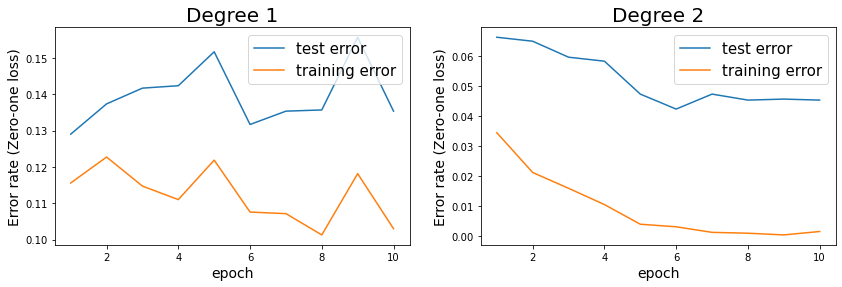

In [25]:
# Comparison Vanilla Perceptron (degree = 1 VS degree = 2)
fig, axes = plt.subplots(1, 2,figsize = (14,4))
axes[0].plot(ep, np.array(test_score_Vanilla1), ep, np.array(tr_score_Vanilla1))
axes[0].legend(["test error",  "training error"], fontsize=15)
axes[0].set_title("Degree 1", fontsize = 20)
axes[0].set_xlabel("epoch", fontsize=14)
axes[0].set_ylabel("Error rate (Zero-one loss)", fontsize=14)

axes[1].plot(ep[:10], np.array(test_score_vanilla)[:10], ep[:10], np.array(tr_score_vanilla)[:10])
axes[1].legend(["test error",  "training error"], fontsize=15)
axes[1].set_title("Degree 2", fontsize = 20)
axes[1].set_xlabel("epoch", fontsize=14)
axes[1].set_ylabel("Error rate (Zero-one loss)", fontsize=14)

In [32]:
vanilla_test_score_dr, vanilla_tr_score_dr = [], []
for degree in range(1, 7):
    mcl = MultiClassifier(degree = degree, epochs = 5, binary_classifier=PerceptronVanilla)
    mcl.fit(x_train, y_train)
    vanilla_test_score_dr.append(mcl.score(x_test, y_test))
    vanilla_tr_score_dr.append(mcl.score(x_train, y_train))  

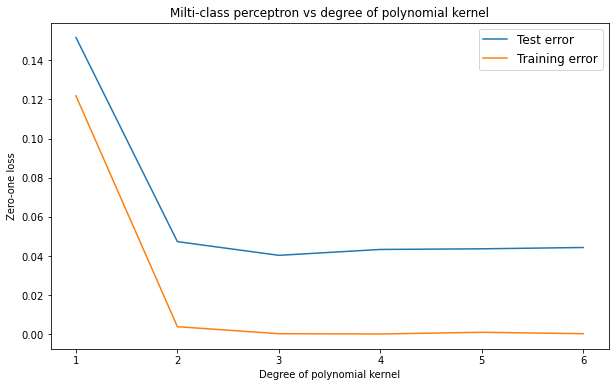

In [41]:
plt.figure(figsize=(10,6))
plt.plot(gr, np.array(vanilla_test_score_dr),  label = "Test error")
plt.plot(gr, np.array(vanilla_tr_score_dr) , label = "Training error")
plt.legend(fontsize=12)
plt.title("Milti-class perceptron vs degree of polynomial kernel")
plt.xlabel("Degree of polynomial kernel")
plt.ylabel("Zero-one loss")
#plt.savefig('degree_vanilla.pdf')
plt.show()

In [29]:
test_score_ave, tr_score_ave = [], []
for epoch in range(1, 11):
    mcl = MultiClassifier(epochs = epoch, binary_classifier=PerceptronAve)
    mcl.fit(x_train, y_train)
    test_score_ave.append(mcl.score(x_test, y_test))
    tr_score_ave.append(mcl.score(x_train, y_train))

In [30]:
test_score_erm, tr_score_erm = [], []
for epoch in range(1, 11):
    mcl = MultiClassifier(epochs = epoch, binary_classifier=PerceptronERM)
    mcl.fit(x_train, y_train)
    test_score_erm.append(mcl.score(x_test, y_test))
    tr_score_erm.append(mcl.score(x_train, y_train))

Text(0, 0.5, 'Error rate (Zero-one loss)')

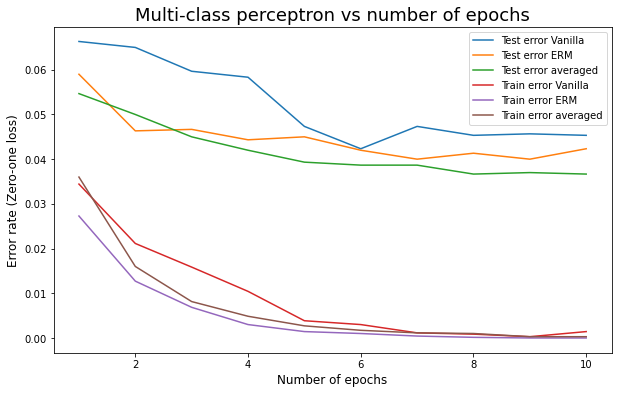

In [31]:
plt.figure(figsize=(10,6))
plt.plot(ep, np.array(test_score_vanilla) ,  label = 'Test error Vanilla')
plt.plot(ep, np.array(test_score_erm) , label = 'Test error ERM')
plt.plot(ep, np.array(test_score_ave) ,  label = 'Test error averaged')
plt.plot(ep, np.array(tr_score_vanilla) ,  label = 'Train error Vanilla')
plt.plot(ep, np.array(tr_score_erm) , label = 'Train error ERM')
plt.plot(ep, np.array(tr_score_ave) ,  label = 'Train error averaged')
plt.legend(loc=1, fontsize=10)
plt.title("Multi-class perceptron vs number of epochs", fontsize=18)
plt.xlabel("Number of epochs", fontsize=12)
plt.ylabel("Error rate (Zero-one loss)", fontsize=12)

In [33]:
erm_test_score_dr, erm_tr_score_dr = [], []
for degree in range(1, 7):
    mcl = MultiClassifier(degree = degree, epochs = 5, binary_classifier=PerceptronERM)
    mcl.fit(x_train, y_train)
    erm_tr_score_dr.append(mcl.score(x_train, y_train))
    erm_test_score_dr.append(mcl.score(x_test, y_test))

In [34]:
ave_test_score_dr , ave_train_score_dr = [], []
for degree in range(1, 7):
    mcl = MultiClassifier(degree = degree, epochs = 5, binary_classifier=PerceptronAve)
    mcl.fit(x_train, y_train)
    ave_train_score_dr.append(mcl.score(x_train, y_train))
    ave_test_score_dr.append(mcl.score(x_test, y_test))

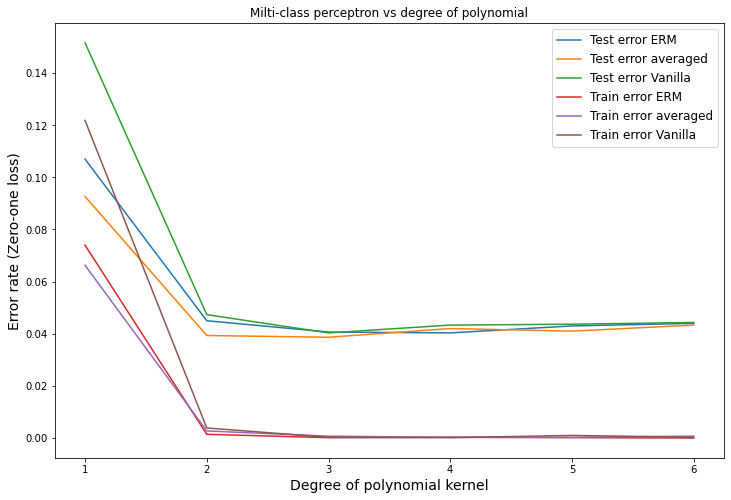

In [36]:
plt.figure(figsize=(12,8))
plt.plot(gr, np.array(erm_test_score_dr) ,  label = "Test error ERM")
plt.plot(gr, np.array(ave_test_score_dr) , label = "Test error averaged")
plt.plot(gr, np.array(vanilla_test_score_dr) , label = "Test error Vanilla")
plt.plot(gr, np.array(erm_tr_score_dr) , label = 'Train error ERM')
plt.plot(gr, np.array(ave_train_score_dr) ,  label = 'Train error averaged')
plt.plot(gr, np.array(vanilla_tr_score_dr), label = "Train error Vanilla")
    
plt.legend( loc=1,fontsize=15)
plt.title("Milti-class perceptron vs degree of polynomial")
plt.legend(loc=1, fontsize=12)
plt.xlabel("Degree of polynomial kernel", fontsize=14)
plt.ylabel("Error rate (Zero-one loss)", fontsize=14)
#plt.savefig("degree_loss.pdf")
plt.show()

In [39]:
# Trining the best model( Averaged Perceptron) with epochs = 5 and degree = 2
multi_cl = MultiClassifier(degree = 2, epochs = 5, binary_classifier=PerceptronAve)
multi_cl.fit(x_train, y_train)
multi_cl.score(x_test, y_test)

0.03933333333333333

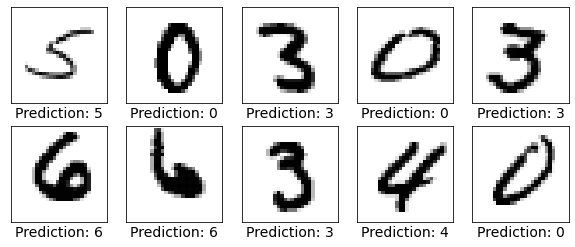

In [40]:
# Final check
samples_to_display = 10
sample_indices = np.random.choice(x_test.shape[0], size=samples_to_display, replace=False)
plt.figure(figsize = (10,4))
for idx in range(samples_to_display):
    plt.subplot(2, 5, idx+1 )
    x_plt = x_test[:,:784]
    plt.imshow(1 - x_plt[sample_indices[idx]].reshape((28, 28)), cmap="gray")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Prediction: {}'.format(multi_cl.pred_labels[sample_indices[idx]]),fontsize=14 )
#plt.savefig("sample_class.pdf")
plt.show()